In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set(style='whitegrid')

# Loading the cleaned dataset
try:
    df = pd.read_csv('cleaned_data.csv')
    print('The Data is loaded successfully')
except FileNotFoundError:
    raise FileNotFoundError('Error: cleaned_data.csv not found. Check the file path for it.')

required_columns = ['average_rating', 'rating_number', 'brand', 'main_category']
missing = [col for col in required_columns if col not in df.columns]
if missing:
    raise ValueError(f" Missing required columns: {missing}")

numeric_check = df[['average_rating', 'rating_number']].apply(
    lambda col: pd.to_numeric(col, errors='coerce').notna().all()
)

if not numeric_check.all():
    raise TypeError(" The 'average_rating' and 'rating_number' must be numeric.")


The Data is loaded successfully


In [40]:
# Selecting and encoding features
features = df[['average_rating', 'rating_number', 'brand', 'main_category']].copy()

# Encoding categorical features 
features['brand_encoded'] = LabelEncoder().fit_transform(features['brand'].astype(str))
features['cat_encoded'] = LabelEncoder().fit_transform(features['main_category'].astype(str))


X = features[['average_rating', 'rating_number', 'brand_encoded', 'cat_encoded']]

In [41]:
# Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
try:
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
    features['cluster'] = kmeans.fit_predict(X_scaled)
    df['cluster'] = features['cluster']
except Exception as e:
    raise RuntimeError(f"Clustering failed: {e}")

# Cluster summary
cluster_summary = features.groupby('cluster').agg(
    avg_rating=('average_rating', 'mean'),
    avg_reviews=('rating_number', 'mean'),
    avg_brand_id=('brand_encoded', 'mean'),
    avg_cat_id=('cat_encoded', 'mean'),
    count=('cluster', 'count')
).round(2)

print("\nCluster Summary:")
print(cluster_summary)



Cluster Summary:
         avg_rating  avg_reviews  avg_brand_id  avg_cat_id   count
cluster                                                           
0              4.26       418.87       6807.06        0.00  164262
1              3.00       109.06       9574.71        0.00   49408
2              3.66       160.58      21805.13        0.00  119919
3              4.52      8864.56      16141.35        0.00   13381
4              4.47       609.73      21443.76        0.04  125436


C:\Users\student\AppData\Local\Temp\ipykernel_1452\3688894935.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features, x='cluster', palette='Set2')


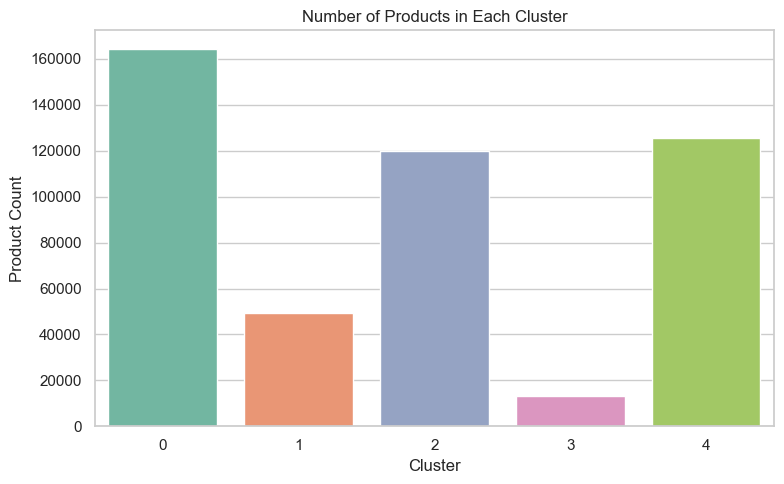

In [42]:
#Cluster Count Visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=features, x='cluster', palette='Set2')
plt.title("Number of Products in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Product Count")
plt.tight_layout()
plt.show()

C:\Users\student\AppData\Local\Temp\ipykernel_1452\601911892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features, x='cluster', y='average_rating', palette='Set3')


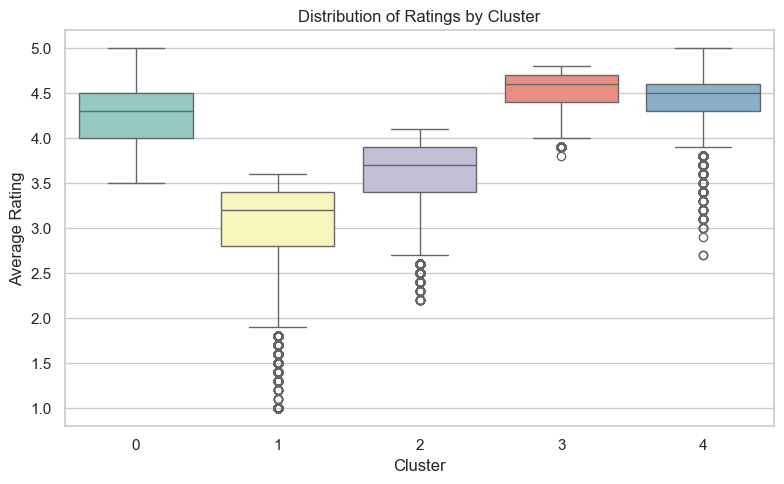

In [43]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=features, x='cluster', y='average_rating', palette='Set3')
plt.title("Distribution of Ratings by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

In [44]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
features['pca1'] = X_pca[:, 0]
features['pca2'] = X_pca[:, 1]

In [45]:
cluster_labels = {
    0: "High Quality, Mid Engagement",
    1: "Low Rated, Low Engagement",
    2: "Moderate Products",
    3: "High Rated, High Engagement",
    4: "Emerging Favorites"
}
features['cluster_label'] = features['cluster'].map(cluster_labels)
df['cluster_label'] = features['cluster_label']

In [46]:
# Top Products per Cluster
top_products = df.groupby('cluster').apply(
    lambda g: g.nlargest(3, 'average_rating')[['brand', 'main_category', 'average_rating', 'rating_number']]
).reset_index(drop=True)
print("Top Products per Cluster:")
display(top_products)

Top Products per Cluster:


C:\Users\student\AppData\Local\Temp\ipykernel_1452\359279188.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products = df.groupby('cluster').apply(


,brand,main_category,average_rating,rating_number
0,Camille Beckman,All Beauty,5.0,5
1,BioSilk,All Beauty,5.0,3
2,BioSilk,All Beauty,5.0,3
3,IMTUN,All Beauty,3.6,87
4,Joyci,All Beauty,3.6,16
5,GIANNAY,All Beauty,3.6,383
6,POWERGROOMING,All Beauty,4.1,35
7,Unknown,All Beauty,4.1,6
8,SOOCAS,All Beauty,4.1,112
9,Garage Sale Pup,All Beauty,4.8,10775


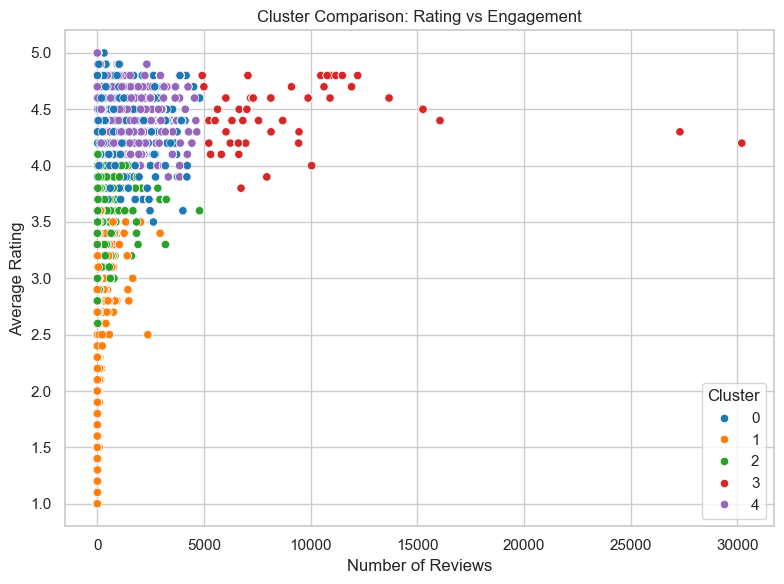

In [47]:

# Rating vs Engagement Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='rating_number', y='average_rating', hue='cluster', palette='tab10')
plt.title("Cluster Comparison: Rating vs Engagement")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Rating")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

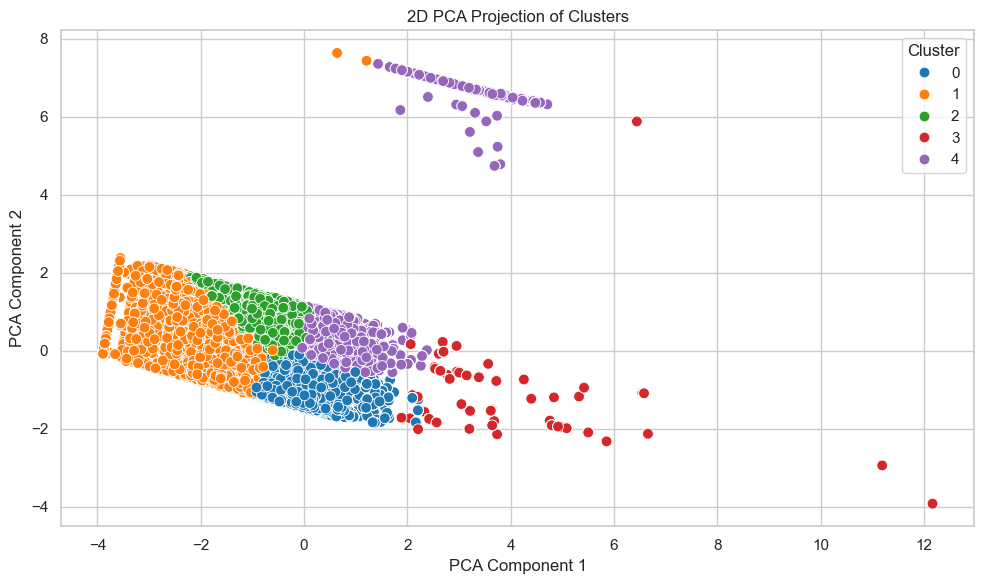

In [48]:
# Visualizing cluster counts with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title("2D PCA Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [49]:
#Ranking clusters by performance
ranked = cluster_summary.copy()
ranked['rating_rank'] = ranked['avg_rating'].rank(ascending=False).astype(int)
ranked['engagement_rank'] = ranked['avg_reviews'].rank(ascending=False).astype(int)
display(ranked.sort_values('rating_rank'))

,avg_rating,avg_reviews,avg_brand_id,avg_cat_id,count,rating_rank,engagement_rank
cluster,,,,,,,
3,4.52,8864.56,16141.35,0.00,13381,1,1
4,4.47,609.73,21443.76,0.04,125436,2,2
0,4.26,418.87,6807.06,0.00,164262,3,3
2,3.66,160.58,21805.13,0.00,119919,4,4
1,3.00,109.06,9574.71,0.00,49408,5,5


Applied K-Means clustering (k = 5) to segment products based on average rating, number of reviews, brand, and category. Each product was encoded using label encoding for brand and category and scaled using standard normalization.

**Cluster Interpretations:**
- **Cluster 0**: Comprises products with high ratings and a moderate number of reviews. Average brand and category IDs suggest mid-range popularity and niche domains.
- **Cluster 1**: Characterized by low average ratings and lower review counts. Often includes lesser-known brands or unpopular categories.
- **Cluster 2**: Features high review counts and above-average ratings, typically from well-known brands in dominant product categories.
- **Cluster 3**: Small cluster with mixed ratings but very low review numbers, possibly new or niche items.
- **Cluster 4**: Balanced average rating and review volume, representing a general consumer sentiment category.

The PCA plot shows distinct cluster separation, validating our segmentation approach.